In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textblob
import nltk
from nltk.corpus import twitter_samples
import wordcloud
from nltk.probability import FreqDist


In [2]:
from textblob import TextBlob
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import string
import emoji

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

In [4]:
nltk.download('twitter_samples')


[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [8]:
print("Positive Tweets:")
for tweet in positive_tweets[:5]: 
    print(tweet)
print("\nNegative Tweets:")
for tweet in negative_tweets[:5]: 
    print(tweet)

Positive Tweets:
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
@97sides CONGRATS :)
yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days

Negative Tweets:
hopeless for tmr :(
Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(
@Hegelbon That heart sliding into the waste basket. :(
“@ketchBurning: I hate Japanese call him "bani" :( :(”

Me too
Dang starting next week I have "work" :(


In [9]:
df_positive = pd.DataFrame(positive_tweets, columns=['tweet'])
df_positive['sentiment'] = 1  # positive sentiment is 1
df_negative = pd.DataFrame(negative_tweets, columns=['tweet'])
df_negative['sentiment'] = 0  # negative sentiment is 0
df = pd.concat([df_positive, df_negative])
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

,tweet,sentiment
0,@KageYashsa Shopping for a bit :p,1
1,my layout doesn't match but it's the closest I...,0
2,"Lions agains Otani, 3-0 down already at 3rd bo...",0
3,@AldiUSA love your store!!! Best chocolate sel...,1
4,maroon cocktail dresses http://t.co/Ioj5YzNRwu...,1
5,"Ah Millz askies :( ""@_Millzxy3D: so you come b...",0
6,@Inugamikun Wub Cerbchan? :D,1
7,@NiallOfficial gn love u see u in 2 days :),1
8,Craving for Banana Crumble McFlurry and Fries :(,0
9,@NefariousBella9 @laurenkatebooks @Fallen_Seri...,1


# Exploratory Data Analysis

In [11]:
print(df['sentiment'].value_counts())

1    5000
0    5000
Name: sentiment, dtype: int64


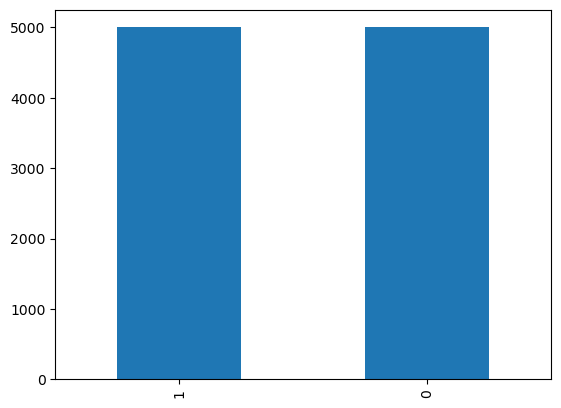

In [12]:
df['sentiment'].value_counts().plot(kind='bar')
plt.show()

count    10000.000000
mean        68.537700
std         37.138461
min          7.000000
25%         37.000000
50%         61.000000
75%         97.000000
max        152.000000
Name: length, dtype: float64


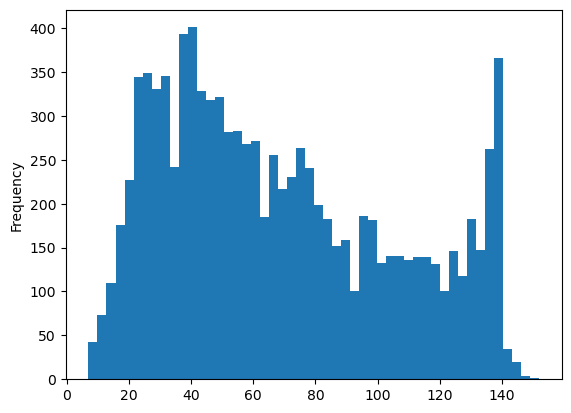

In [13]:
df['length'] = df['tweet'].apply(len)
print(df['length'].describe())
df['length'].plot(kind='hist', bins=50)
plt.show()

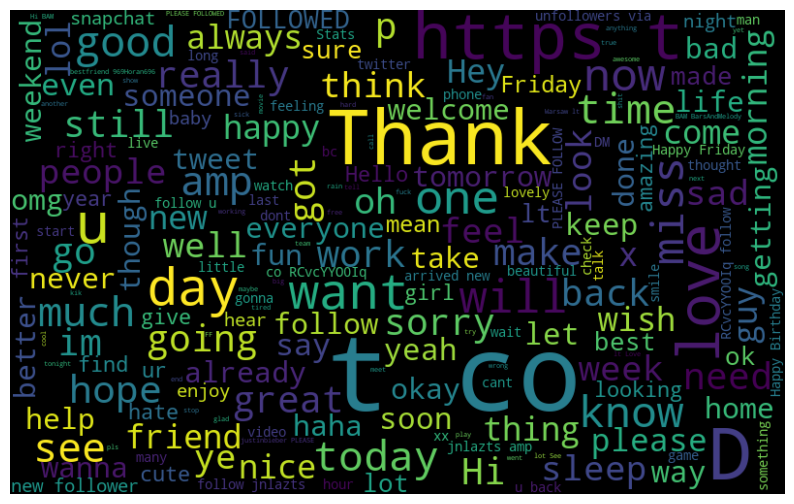

In [14]:
from wordcloud import WordCloud
all_words = ' '.join(df['tweet'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

count    10000.000000
mean        11.639700
std          6.580275
min          1.000000
25%          6.000000
50%         10.000000
75%         16.000000
max         35.000000
Name: word_count, dtype: float64


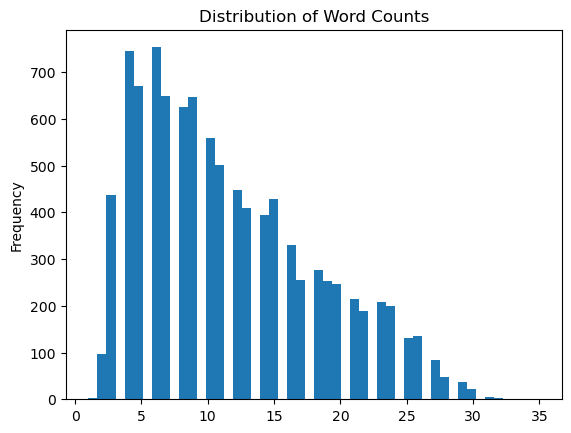

In [15]:
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
print(df['word_count'].describe())
df['word_count'].plot(kind='hist', bins=50)
plt.title('Distribution of Word Counts')
plt.show()

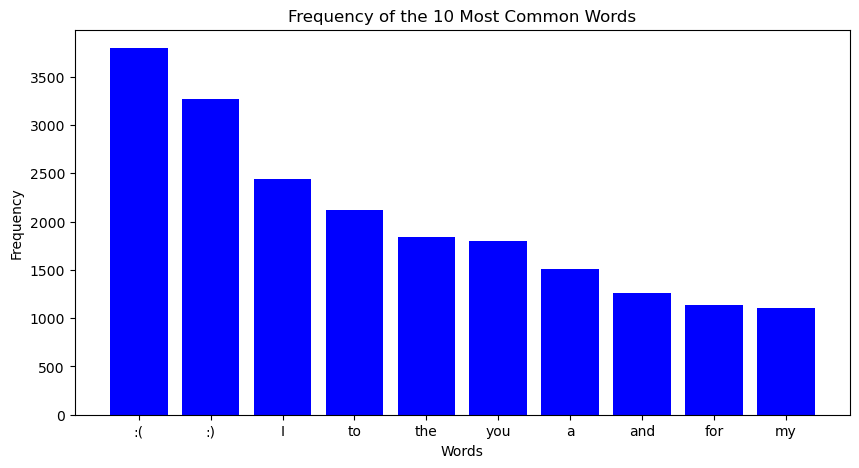

In [16]:
from collections import Counter
all_words = [word for tweet in df['tweet'] for word in tweet.split()]
word_counts = Counter(all_words)
common_words = word_counts.most_common(10)
words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='b')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of the 10 Most Common Words')
plt.show()

# Preprocessing

## Cleaning the Text

In [17]:
def clean_text(text):

    text = str(text).lower()
    
    # Remove Twitter handles
    text = re.sub('@\w+', '', text)
    
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    
    # Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove new line characters
    text = re.sub('\n', '', text)
    
    # Remove words that contain numbers
    text = re.sub('\w*\d\w*', '', text)
    
    # Convert emojis to words
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    return text

In [18]:
print("Data before preprocessing")
df['tweet'].head(5)

Data before preprocessing


0                    @KageYashsa Shopping for a bit :p
1    my layout doesn't match but it's the closest I...
2    Lions agains Otani, 3-0 down already at 3rd bo...
3    @AldiUSA love your store!!! Best chocolate sel...
4    maroon cocktail dresses http://t.co/Ioj5YzNRwu...
Name: tweet, dtype: object

In [19]:
df['cleaned_tweet'] = df['tweet'].apply(clean_text)
print("Data after preprocessing")
print(df['cleaned_tweet'].head(5))

Data after preprocessing
0                                 shopping for a bit p
1    my layout doesnt match but its the closest i c...
2    lions agains otani  down already at  bottom no...
3           love your store best chocolate selections 
4          maroon cocktail dresses  mididresses for   
Name: cleaned_tweet, dtype: object


## Tokenization

In [20]:
df['tokenized_tweet']=df['cleaned_tweet'].apply(word_tokenize)
print("Data after tokenization")
df['tokenized_tweet'].head(5)

Data after tokenization


0                           [shopping, for, a, bit, p]
1    [my, layout, doesnt, match, but, its, the, clo...
2    [lions, agains, otani, down, already, at, bott...
3     [love, your, store, best, chocolate, selections]
4        [maroon, cocktail, dresses, mididresses, for]
Name: tokenized_tweet, dtype: object

## Removing Stop Words

In [22]:
stop_words = set(stopwords.words('english'))
print("The stop words are\n",stop_words)


The stop words are
 {'are', 'your', 'theirs', 'as', 'being', "mightn't", 'whom', 'myself', 'up', 's', 'itself', 'you', 'themselves', "that'll", 'some', 'those', 'hasn', 'and', 'her', 'most', 'haven', 'yourself', 'further', 'weren', "wouldn't", 'didn', 'after', 'he', 'him', 'ma', 'ours', 'been', 'o', 'can', 'ourselves', 'off', "hadn't", 'through', "hasn't", 'these', 'my', 'too', 'himself', 'have', 'me', 're', 'our', 'what', 'is', 'why', 'just', 'the', 'isn', 'needn', 'over', 'if', 'wouldn', 'by', 'nor', 'while', 'won', 'doesn', 'same', 'shan', 'which', 'about', 'mightn', 'on', 'each', 'will', 'a', 'an', 'such', 'she', 'mustn', 'against', 'be', 'has', 've', 'out', "needn't", 'yourselves', "should've", "doesn't", "couldn't", 'all', 'in', 'before', 'couldn', 'own', 'his', 'having', 'down', 'there', 'y', 'to', 'am', "shouldn't", 't', 'between', 'during', "weren't", 'was', "you'd", 'very', "didn't", 'm', 'then', 'but', 'until', 'both', 'wasn', "you've", "aren't", 'any', 'do', 'd', 'had', "mu

In [23]:
df['tokenized_tweet'] = df['tokenized_tweet'].apply(lambda x: [word for word in x if word not in stop_words])
print("Data after removing stopwords:")
print(df['tokenized_tweet'].head(5))

Data after removing stopwords:
0                                   [shopping, bit, p]
1    [layout, doesnt, match, closest, could, find, ...
2    [lions, agains, otani, already, bottom, chance...
3           [love, store, best, chocolate, selections]
4             [maroon, cocktail, dresses, mididresses]
Name: tokenized_tweet, dtype: object


## POS Tagging

In [24]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [25]:
df['pos_tagged_tweet'] = df['tokenized_tweet'].apply(lambda x: nltk.pos_tag(x))
print("Data after POS tagging")
print(df['pos_tagged_tweet'].head(5))

Data after POS tagging
0                [(shopping, VBG), (bit, NN), (p, NN)]
1    [(layout, NN), (doesnt, NN), (match, NN), (clo...
2    [(lions, NNS), (agains, VBZ), (otani, JJ), (al...
3    [(love, VB), (store, NN), (best, JJS), (chocol...
4    [(maroon, NN), (cocktail, NN), (dresses, VBZ),...
Name: pos_tagged_tweet, dtype: object


## Lemmatization

In [26]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
lemmatizer = WordNetLemmatizer()

df['lemmatized_tweet'] = df['pos_tagged_tweet'].apply(lambda x: [lemmatizer.lemmatize(word[0]) for word in x])

print("Data after lemmatization:")

df['lemmatized_tweet'].head(5)

Data after lemmatization:


0                                   [shopping, bit, p]
1    [layout, doesnt, match, closest, could, find, ...
2    [lion, agains, otani, already, bottom, chance,...
3            [love, store, best, chocolate, selection]
4               [maroon, cocktail, dress, mididresses]
Name: lemmatized_tweet, dtype: object

In [48]:
df['lemmatized_tweet']=df['lemmatized_tweet'].dropna()

## Splitting of Data into Train and Test Set

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_tweet'], df['sentiment'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.apply(' '.join))
X_test = vectorizer.transform(X_test.apply(' '.join))
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 8000
Test set size: 2000


## Training Logisctic Model

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       986
           1       0.78      0.71      0.75      1014

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



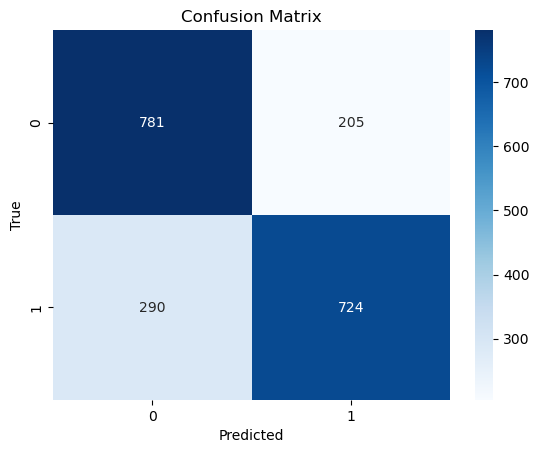

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
print("F2 Score:", f2_score)

Accuracy: 0.7525
Precision: 0.754629572675859
Recall: 0.7525
F2 Score: 0.7520538734848613


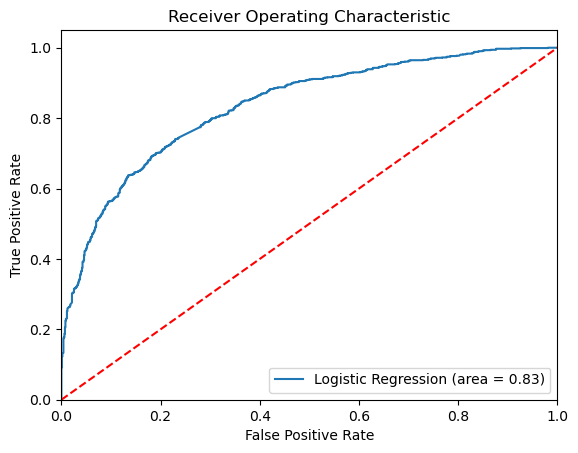

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

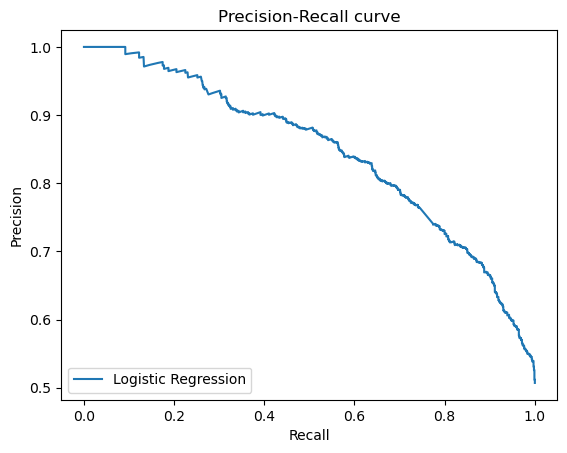

In [33]:
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(recall, precision, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

## Training Naive Bias Model

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       986
           1       0.78      0.72      0.75      1014

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



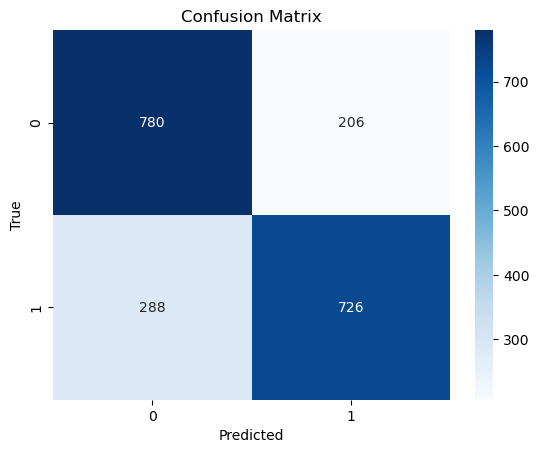

In [34]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)
print(classification_report(y_test, nb_y_pred))
cmnb = confusion_matrix(y_test, nb_y_pred)
sns.heatmap(cmnb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [35]:
accuracy_nb = accuracy_score(y_test, nb_y_pred)
print("Accuracy:", accuracy_nb)
precision_nb = precision_score(y_test, nb_y_pred, average='weighted')   
print("Precision:", precision_nb)
recall_nb = recall_score(y_test, nb_y_pred, average='weighted')
print("Recall:", recall_nb)
f2_score_nb = fbeta_score(y_test, nb_y_pred, beta=2, average='weighted')
print("F2 Score:", f2_score_nb)



Accuracy: 0.753
Precision: 0.7549939480156242
Recall: 0.753
F2 Score: 0.7525868357001737


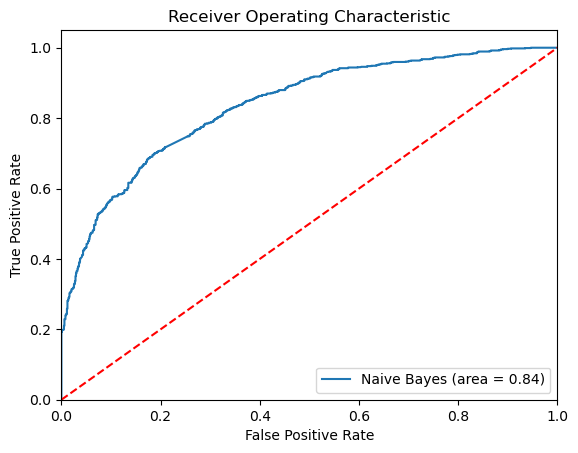

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

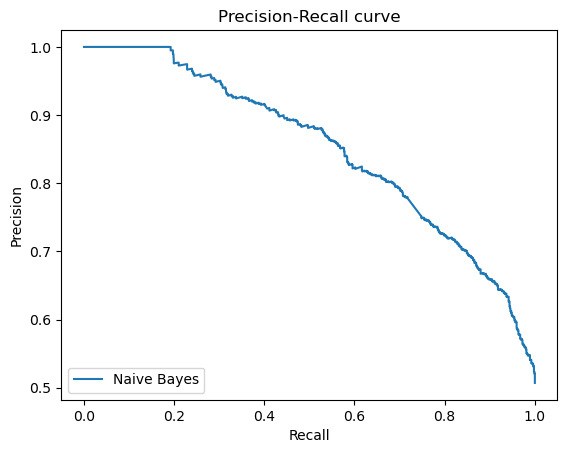

In [37]:
precision, recall, _ = precision_recall_curve(y_test, nb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(recall, precision, label='Naive Bayes')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()